In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

In [6]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

# Load as module

In [7]:
sys.path.append('../mockmodel/')
from TracerFit import mwfit, int_idx

In [14]:
run_id=9
size = 100000
file = "gaia_edr3.gaia_source_b80"
file = "gaia_unwise_sdssspec_b80"

model = {}
for cardinal in ['north', 'south']:
    run_id=6; #size = 100000
    file = "gaia_edr3.gaia_source_b80"
    model[cardinal+'_Mto'] = mwfit(sf_bool=False, perr_bool=False)
    model[cardinal+'_Mto'].load(f'/data/asfe2/Projects/mwtrace_data/gaia/gaia_{file}_{size}_{cardinal}_Mto_{run_id:03d}.h')
    
#     if cardinal=='south': run_id=8;# size='full'
#     else: run_id=7
    run_id=9
    file = "gaia_unwise_sdssspec_b80"
    model[cardinal] = mwfit(sf_bool=False, perr_bool=False)
    model[cardinal].load(f'/data/asfe2/Projects/mwtrace_data/gaia/gaia_{file}_{size}_{cardinal}_sf_perr_{run_id:03d}.h')

dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])


# Load data

In [16]:
# Load Sample
sample = {'north':{}, 'south':{}};
filename = f'/data/asfe2/Projects/mwtrace_data/gaia/{file}.h'
with h5py.File(filename, 'r') as hf:
    for cardinal in ['north', 'south']:
        subset = np.intersect1d(hf[cardinal]['source_id'][...], model[cardinal].sample['source_id'], return_indices=True)[1]
        for key in hf[cardinal].keys():
            sample[cardinal][key]=hf[cardinal][key][...][subset]

In [17]:
for cardinal in ['north', 'south']:
    model[cardinal]._generate_fid_pars()
    model[cardinal].sample=sample

Got Selectionfunction pars
Got Selectionfunction pars


# Plot results

In [18]:
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [19]:
model['north'].free_pars, model['north'].fixed_pars

({0: array(['w', 'hz', 'fD'], dtype='<U20'),
  1: array(['w', 'hz', 'fD'], dtype='<U20'),
  2: array(['w', 'hz', 'fD'], dtype='<U20'),
  'shd': array(['alpha1', 'alpha2'], dtype='<U20')},
 {0: {'Mms': array(8),
   'Mms1': array(9),
   'Mms2': array(7),
   'Mto': array(3.1),
   'alpha3': array(-0.6)},
  1: {'Mms': array(8),
   'Mms1': array(9),
   'Mms2': array(7),
   'Mto': array(3.1),
   'alpha3': array(-0.73)},
  2: {'Mms': array(8),
   'Mms1': array(9),
   'Mms2': array(7),
   'Mto': array(3.1),
   'alpha3': array(-0.64)},
  'Mms': array(8),
  'Mms1': array(9),
  'Mms2': array(7),
  'Mx': array(12),
  'R0': array(8.27),
  'theta_deg': array(80)})

(10.0, 40000000)

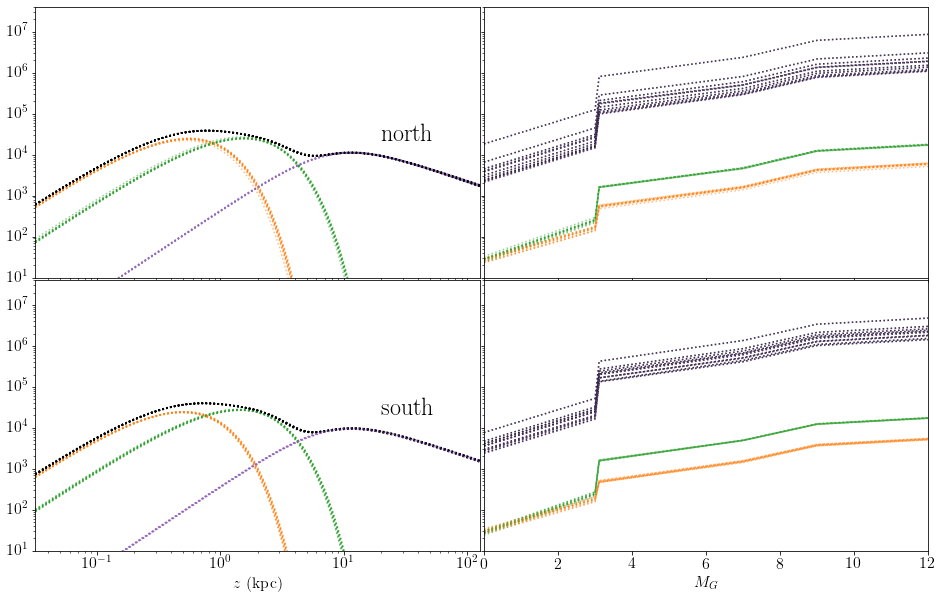

In [20]:
fig, axes = plt.subplots(2,2,figsize=(16,10), sharey=True, sharex='col')

mcmc_kwargs = ({'c':'k','alpha':1, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.5, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.5, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.5, 'linestyle':':'})

cardinals = ['north', 'south']
label = 'sf_perr_mcmc'

for jj, cardinal in enumerate(cardinals):
    fixed_pars = model[cardinal].fixed_pars
    nwalker, nstep, ndim = model[cardinal].mcmc_results['chain'][label].shape
    flat_chain = model[cardinal].mcmc_results['chain'][label][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.1)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    for mcmc_sample in mcmc_samples:
        axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars), **mcmc_kwargs[0])
        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
        for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 
    plt.xlim(10**zlim[0],10**zlim[1])
    #plt.legend()
    plt.text(20,2e4,cardinal,fontsize=24)

    plt.sca(axes[jj,1])
    M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                              np.array([fixed_pars['Mx'], fixed_pars['Mms'], fixed_pars['Mms1'], 
                                        fixed_pars['Mms2']])))
    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars), **mcmc_kwargs[0])
        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 
    plt.xlim(M_arr[0],M_arr[-1])


plt.sca(axes[1,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[1,1]); plt.yscale('log'); plt.xlabel(r'$M_G$')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.ylim(10.,40000000)#100000000)

# plt.savefig(f'figs/{file}_{size}_{run_id:03d}_zM_disthist.png', bbox_inches='tight', dpi=200)

In [21]:
plt.rc('axes', labelsize=ndim*3)
plt.rc('xtick',labelsize=ndim*3)
plt.rc('ytick',labelsize=ndim*3)
plt.rc('legend',fontsize=ndim*4)
plt.rc('font',size=ndim*3)

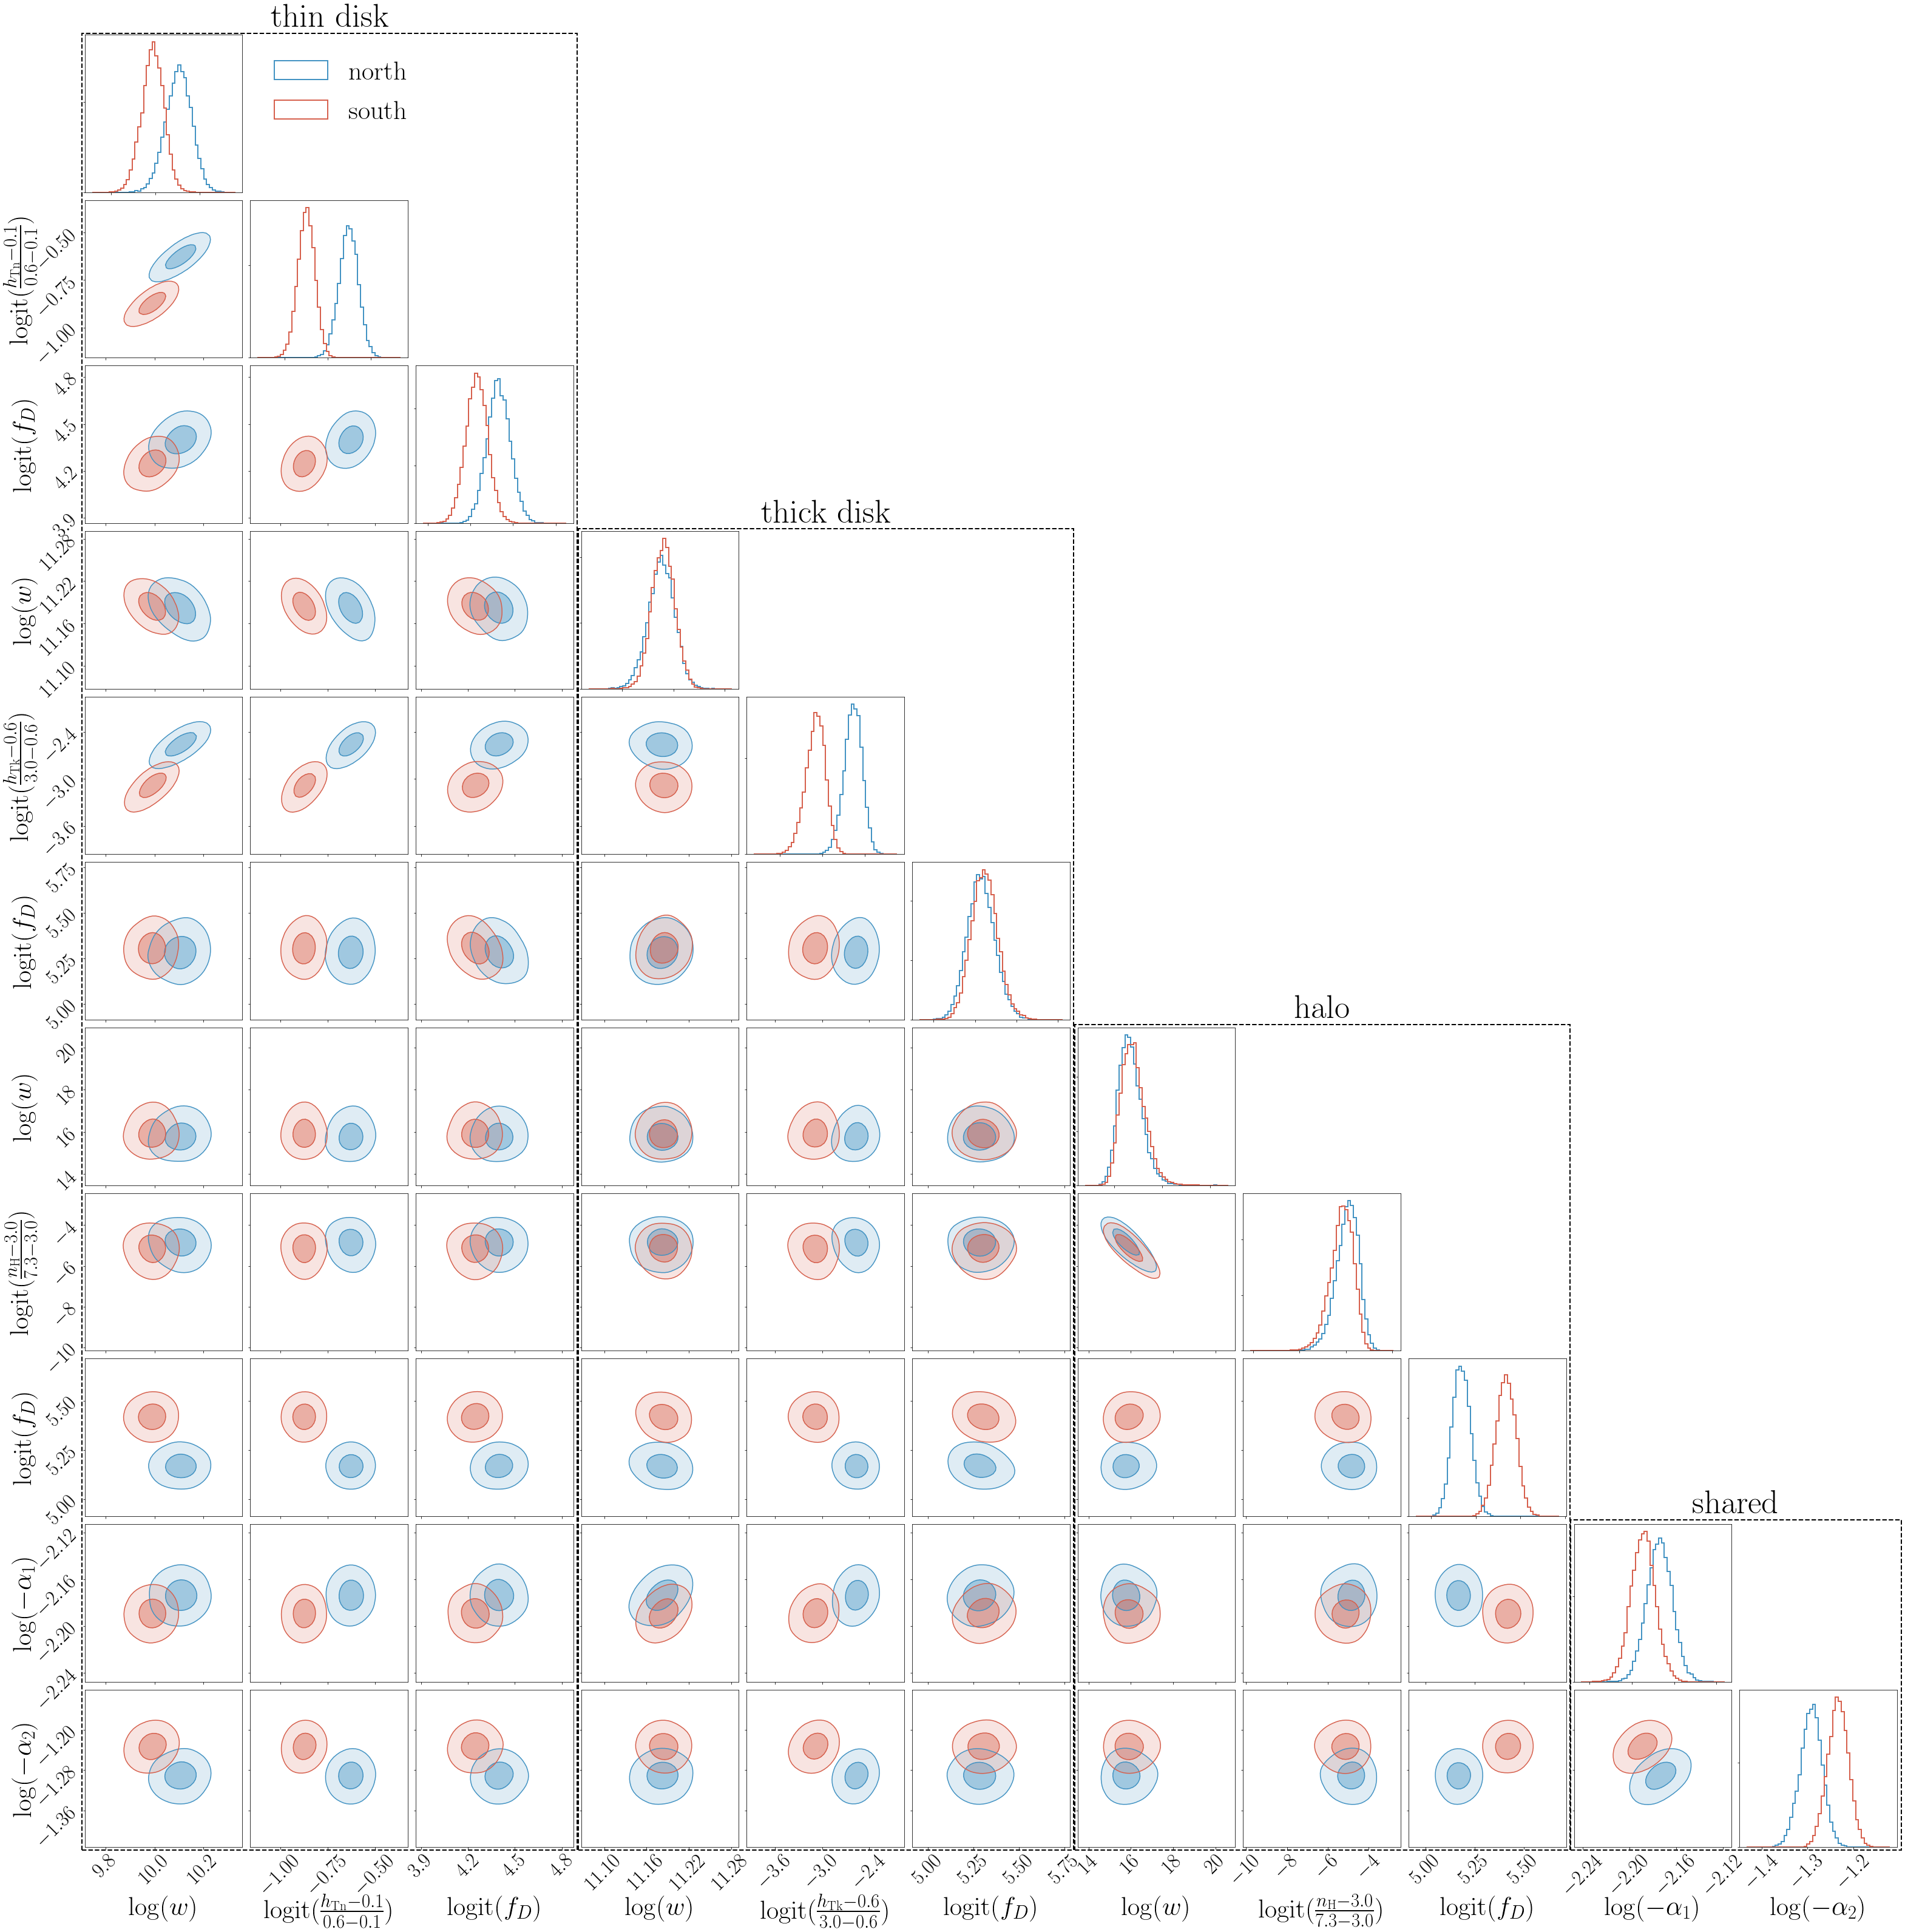

In [22]:
ndim=np.sum([len(model['north'].free_pars[i]) for i in model['north'].free_pars]); 
fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
plotting.layered_corners([model['north'].mcmc_results['chain']['sf_perr_mcmc'],
                          model['south'].mcmc_results['chain']['sf_perr_mcmc']], 
                         index=cardinals, hist_kwargs={'linewidth':2}, 
                         labels=model['north'].get_labels(label_set=transformations.label_set),
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)], fig=fig, ax=axes,
                        label_kwargs={'fontsize':ndim*4})


npar = [len(model['north'].free_pars[i]) for i in model['north'].free_pars]
for jj, cmpt_label in enumerate(['thin disk', 'thick disk', 'halo', 'shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)
    #plt.text()
    
# plt.savefig(f'figs/{file}_{size}_{run_id:03d}_corner_f.png', bbox_inches='tight', dpi=200)

In [33]:
model['north']._generate_fid_pars()
functions = [model['north'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north'].free_pars[j]]

# labels=[];
# for cmpt in np.arange(len(model['north'].components)).tolist()+['shd',]:
#     for par in model['north'].free_pars[cmpt]:
#         labels+=[label_dict[par],]

Got Selectionfunction pars


In [34]:
chains = [model['north'].mcmc_results['chain']['sf_perr_mcmc'].copy(), 
          model['south'].mcmc_results['chain']['sf_perr_mcmc'].copy()]
for i in range(2): chains[i][:,:,[0,3,6]] = np.log10(chains[i][:,:,[0,3,6]])

labels = copy(transformations.label_set)
for i in [0,3,6]: labels[i] = '$\log_{10}(w)$'

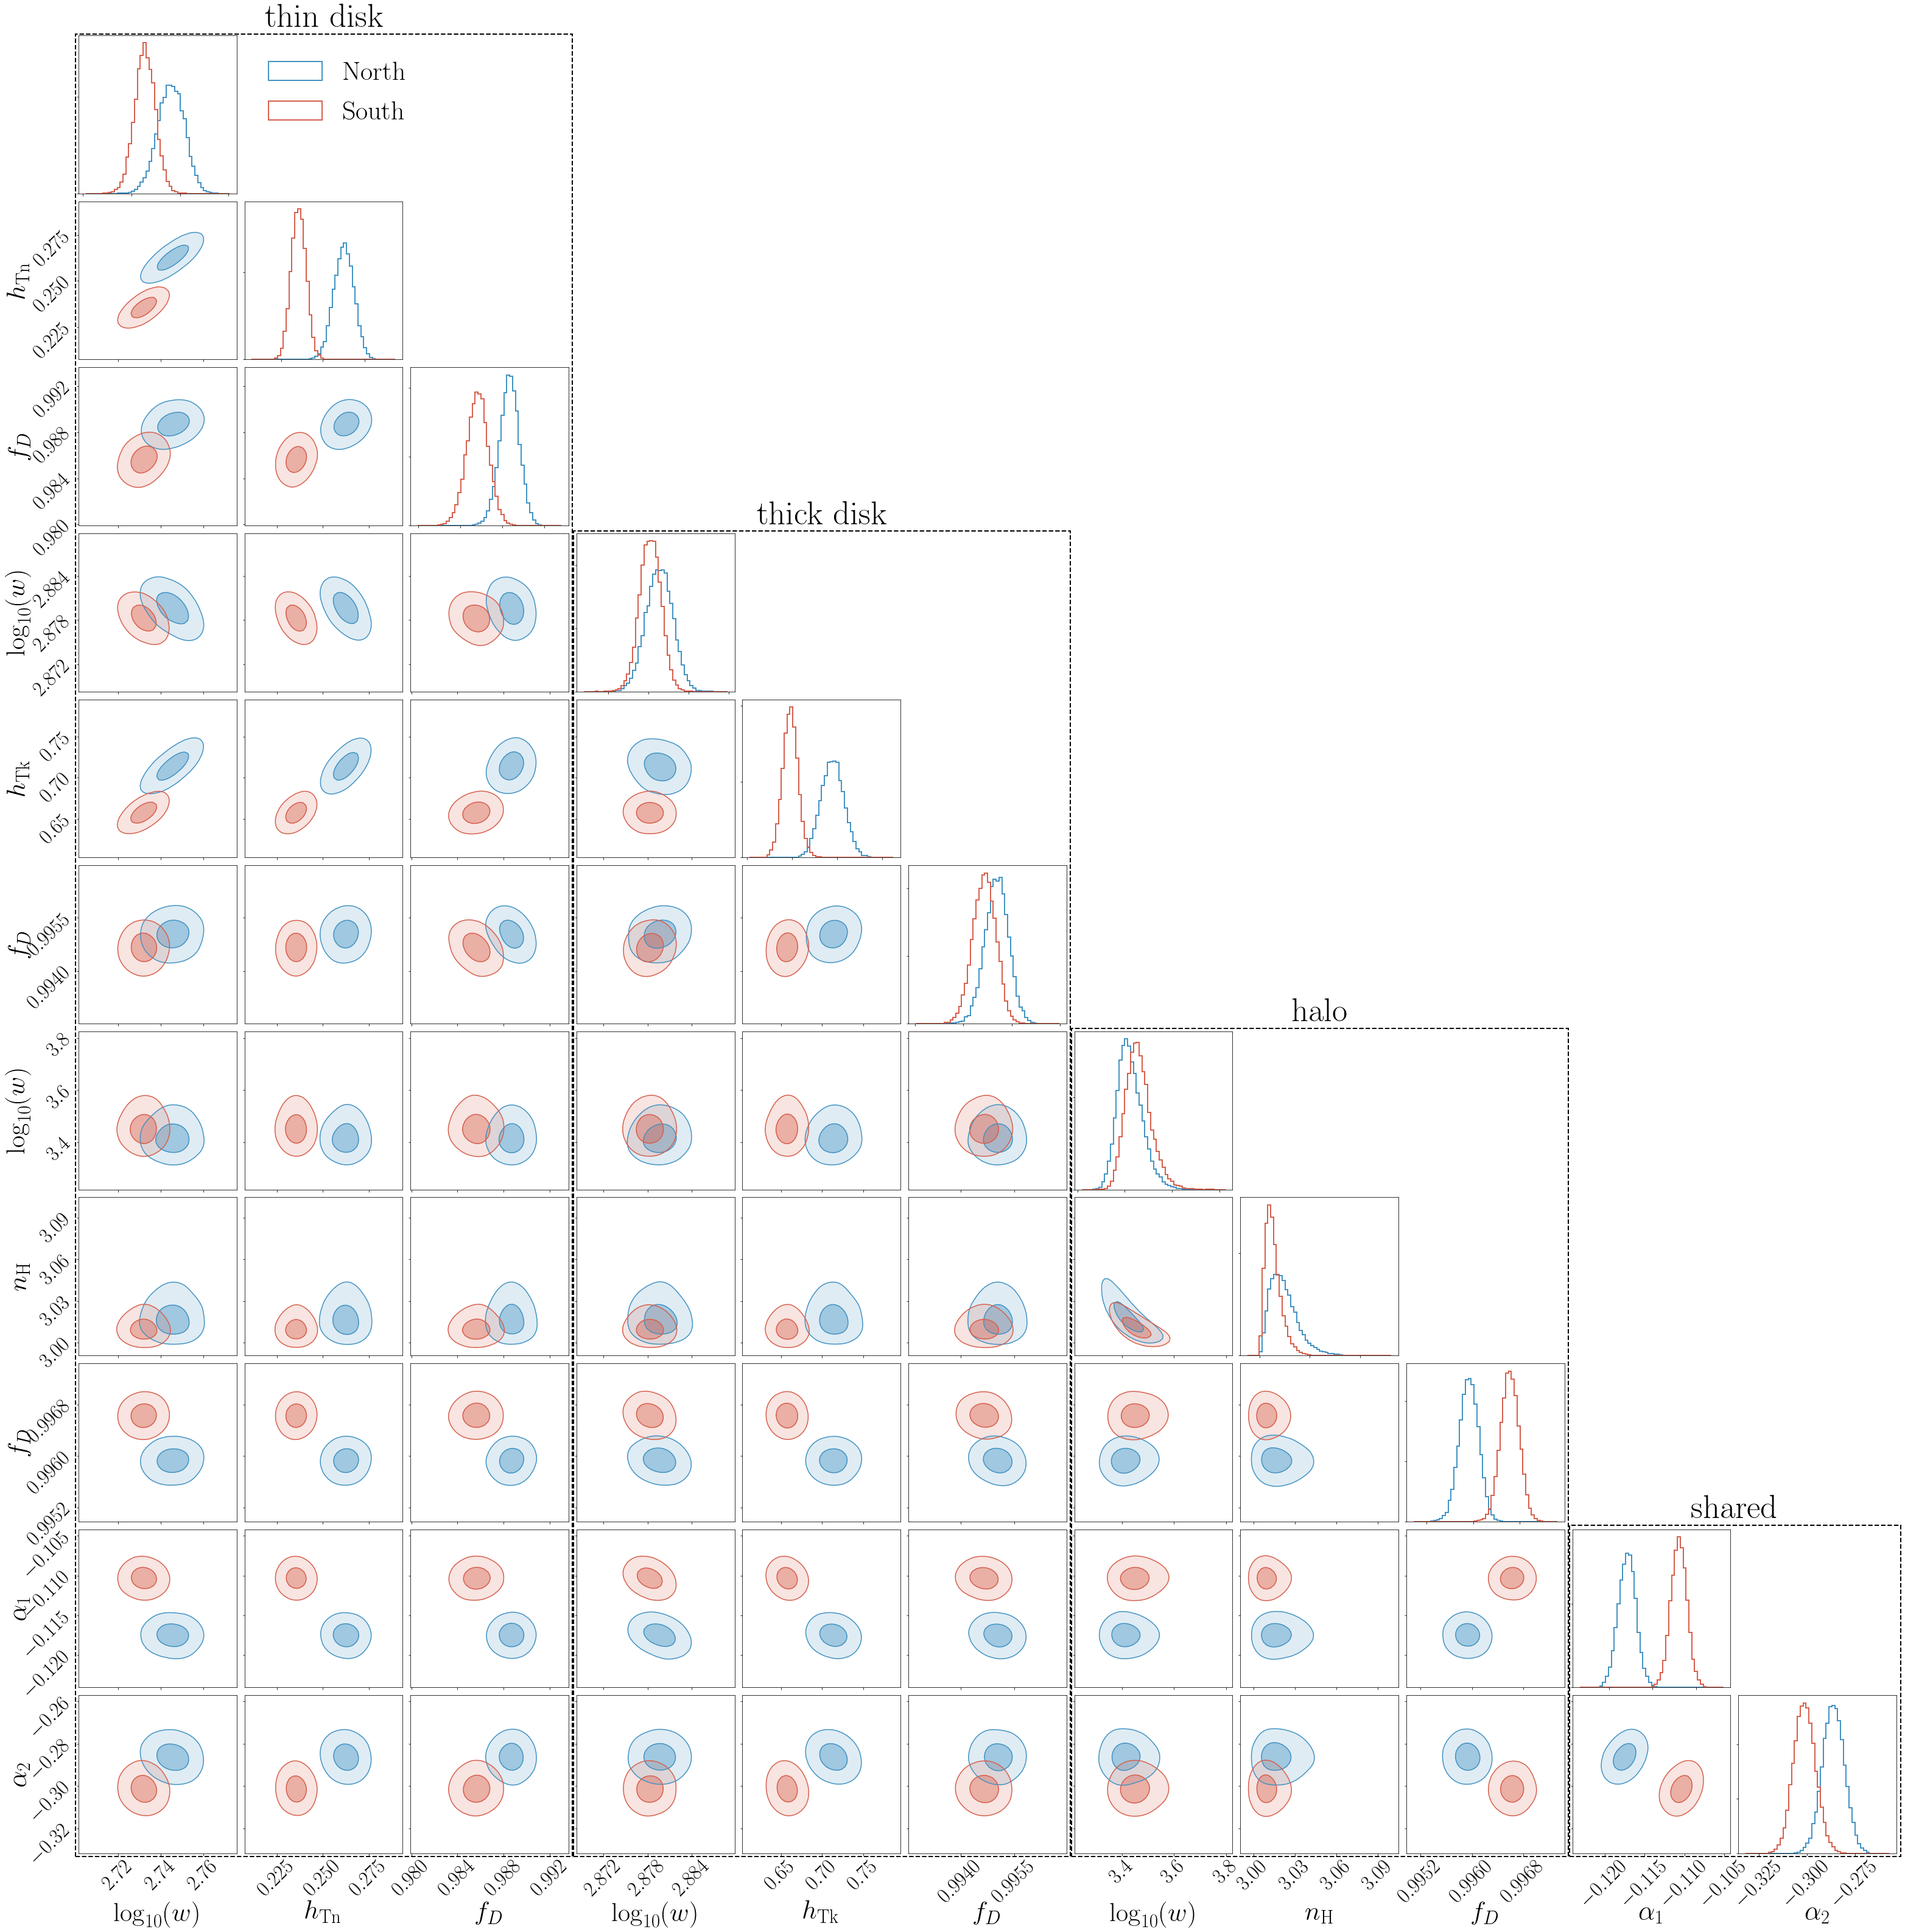

In [35]:
ndim=np.sum([len(model['north'].free_pars[i]) for i in model['north'].free_pars]); 
fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
plotting.layered_corners(chains, 
                         index=['North','South'], hist_kwargs={'linewidth':2}, 
                         labels=labels, functions=functions,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)], fig=fig, ax=axes,
                        label_kwargs={'fontsize':ndim*4})


npar = [len(model['north'].free_pars[i]) for i in model['north'].free_pars]
for jj, cmpt_label in enumerate(['thin disk', 'thick disk', 'halo', 'shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)
    #plt.text()
    
# plt.savefig(f'figs/{file}_{size}_{run_id:03d}_corner.png', bbox_inches='tight', dpi=200)

In [38]:
model['north'].fixed_pars

{0: {'Mms': array(8),
  'Mms1': array(9),
  'Mms2': array(7),
  'Mto': array(3.1),
  'alpha3': array(-0.6)},
 1: {'Mms': array(8),
  'Mms1': array(9),
  'Mms2': array(7),
  'Mto': array(3.1),
  'alpha3': array(-0.73)},
 2: {'Mms': array(8),
  'Mms1': array(9),
  'Mms2': array(7),
  'Mto': array(3.1),
  'alpha3': array(-0.64)},
 'Mms': array(8),
 'Mms1': array(9),
 'Mms2': array(7),
 'Mx': array(12),
 'R0': array(8.27),
 'theta_deg': array(80)}

# Apparent magnitude

In [23]:
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)
plt.rc('font',size=24)

In [24]:
# Get Gaia Selection Function
from selectionfunctions.carpentry import chisel
import selectionfunctions.cog_ii as CoGii
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'
#CoGii.fetch()
dr3_sf = CoGii.dr3_sf(version='modelAB',crowding=False)

config['data_dir'] = '/data/asfe2/Projects/astrometry/PyOutput/'
M = 85; C = 1; jmax=4; lm=0.3; nside=32; ncores=80; B=2.0
map_fname = f"chisquare_astrometry_jmax{jmax}_nside{nside}_M{M}_CGR{C}_lm{lm}_B{B:.1f}_ncores{ncores}_scipy_results.h5"
ast_sf = chisel(map_fname=map_fname, nside=nside, C=C, M=M, lengthscale_m=lm, lengthscale_c=100.,
                basis_options={'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2},
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')
print("SF Mbins: ", ast_sf.Mbins)

Loading auxilliary data ...
Loading selection function ...
Creating selection function interpolator...
t = 4.201 s
  auxilliary:   4.198 s
          sf:   0.002 s
interpolator:   0.001 s
Loading auxilliary data ...
Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside32_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4].h5


/home/andy/py36/lib/python3.6/site-packages/selectionfunctions/SelectionFunctionUtils.py:99: RuntimeWarning: overflow encountered in power
  u = l*(l+1) / np.power(self.B,2.0*j)


Spherical basis file loaded
t = 0.358 s
  auxilliary:   0.035 s
          sf:   0.000 s
interpolator:   0.323 s
SF Mbins:  [ 5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6
  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4
 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2
 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.
 16.2 16.4 16.6 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8
 19.  19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6
 21.8 22. ]


In [25]:
gsf_pars = sf_utils.get_subgaiasf_pars(theta=model['north'].fid_pars['lat_min'], _nside=ast_sf.nside, 
                            dr2_sf=dr3_sf, sub_sf=ast_sf, _m_grid=ast_sf.Mbins)

Higher Res:
Gaia SF:
Ast SF: (222, 86)


In [37]:
gsf_pars = sf_utils.get_subgaiasf_pars(theta=model['north'].fid_pars['lat_min'], _nside=ast_sf.nside, 
                            dr2_sf=dr3_sf, sub_sf=ast_sf, _m_grid=np.arange(5.,30.1,0.2))

Higher Res:
Gaia SF:
Ast SF: (222, 126)


In [38]:
Nmag=500;

app_pars = {}
for key in ['uni_sinb_pixels', 'idx_sinb_pixels', 'pixel_area', 'pixel_id']:
    app_pars[key] = gsf_pars[key].copy()
    
mlim = [5,30]
app_pars['_selectionfunction'] = np.ones((gsf_pars['pixel_id'].size, Nmag))
app_pars['_m_grid'] = np.linspace(*mlim, Nmag)

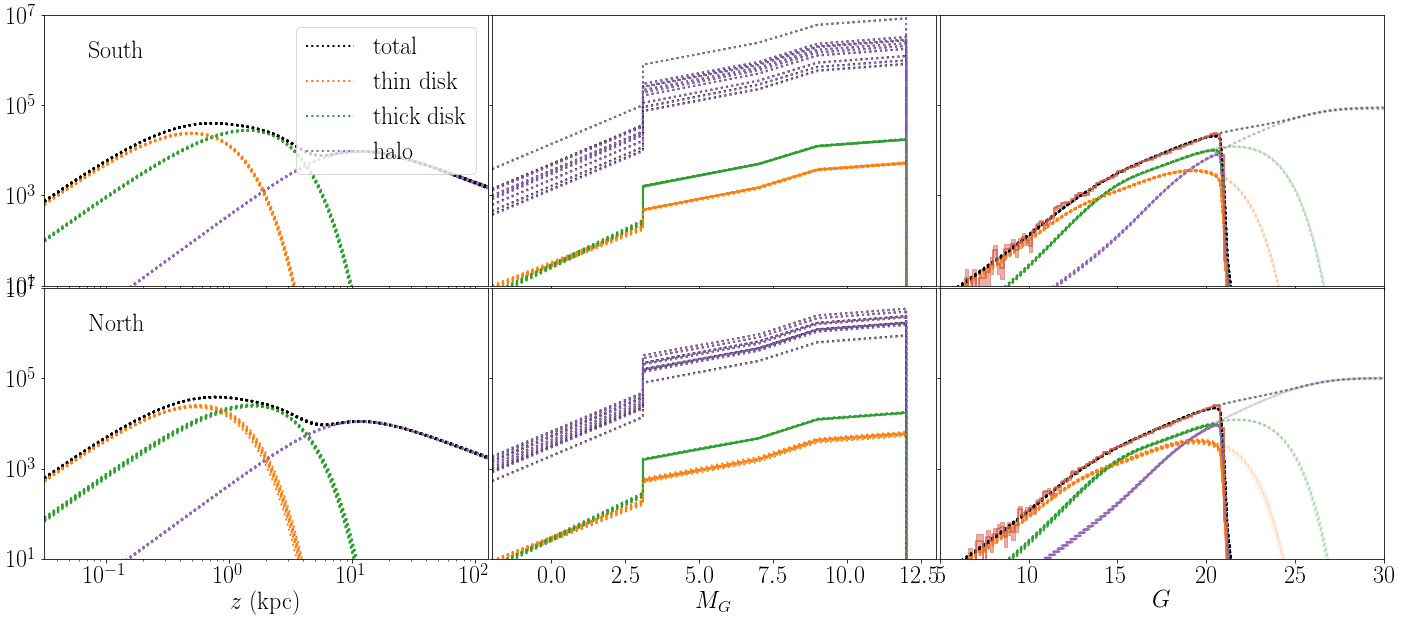

In [47]:
fig, axes = plt.subplots(2,3,figsize=(24,10), sharey=True, sharex='col')

mcmc_kwargs = ({'c':'k','linestyle':':', 'linewidth':2.}, 
               {'c':'tab:orange','linestyle':':', 'linewidth':2.}, 
               {'c':'tab:green','linestyle':':', 'linewidth':2.}, 
               {'c':'tab:purple','linestyle':':', 'linewidth':2.})

labels = ['total', 'thin disk', 'thick disk', 'halo']
cardinals=['south','north']
clabels = {'south':'South', 'north':'North'}

for jj, cardinal in enumerate(cardinals):

    nwalker, nstep, ndim = model[cardinal.lower()].mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model[cardinal.lower()].mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.1)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    for isample, mcmc_sample in enumerate(mcmc_samples):
        if isample==0: axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars), **mcmc_kwargs[0], label=labels[0])
        else: axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars), **mcmc_kwargs[0])
        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars, model='all')
        if isample==0: 
            for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1], label=labels[i+1]) 
        else: 
            for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 

    plt.xlim(10**zlim[0],10**zlim[1])
    if jj==0: plt.legend(loc='upper right')

    plt.sca(axes[jj,1])
    fixed_mags = np.array([model[cardinal.lower()].fixed_pars['Mx'], model[cardinal.lower()].fixed_pars['Mms'], 
                           model[cardinal.lower()].fixed_pars['Mms1'], model[cardinal.lower()].fixed_pars['Mms2'],
                           model[cardinal.lower()].fixed_pars[0]['Mto'], 
                           model[cardinal.lower()].fixed_pars[1]['Mto'], 
                           model[cardinal.lower()].fixed_pars[2]['Mto']])
    M_arr = np.sort(np.hstack((np.linspace(-2.,13.,100), fixed_mags-1e-5, fixed_mags+1e-5)))
    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars), **mcmc_kwargs[0])

        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 
            
            
    plt.sca(axes[jj,2])
#     if jj==0: 
#         plotting.plot_hist(sample[cardinal.lower()]['phot_g_mean_mag'], np.linspace(*mlim,50), ax=axes[jj,2], fill_poisson=True,
#                       plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})

#     if jj==0: model[cardinal.lower()].fid_pars['gsf_pars'] = app_pars
    model[cardinal.lower()].fid_pars['gsf_pars'] = gsf_pars
    m_arr = model[cardinal.lower()].fid_pars['gsf_pars']['_m_grid'].copy()
    for mcmc_sample in mcmc_samples:
        components = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars,
                                                   sf=True)
        axes[jj,2].plot(m_arr, np.sum(components, axis=0), **mcmc_kwargs[0])
        for i in range(3): axes[jj,2].plot(m_arr, components[i], **mcmc_kwargs[i+1]) 
            
        components = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars,
                                                   sf=False)
        axes[jj,2].plot(m_arr, np.sum(components, axis=0), **mcmc_kwargs[0], alpha=0.1)
        for i in range(3): axes[jj,2].plot(m_arr, components[i], **mcmc_kwargs[i+1], alpha=0.1) 
            
            
    hist, bins = np.histogram(sample[cardinal.lower()]['phot_g_mean_mag'], bins=m_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist,2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    plt.plot(x, y, c=cm.RdBu(0.2))
    y0 = np.insert(np.repeat(hist-np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    y1 = np.insert(np.repeat(hist+np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    plt.fill_between(x, y0, y1, color=cm.RdBu(0.2), alpha=0.5)
            

plt.sca(axes[1,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[1,1]); plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1])
plt.sca(axes[1,2]); plt.yscale('log'); plt.xlabel(r'$G$'); plt.xlim(mlim)    
    
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.ylim(1e1,1e7)
#100000000)

for jj, cardinal in enumerate(cardinals):
    ax = axes[jj,0]
    plt.sca(ax)
    plt.text(ax.get_xlim()[0]**0.9 * ax.get_xlim()[1]**0.1,
             ax.get_ylim()[0]**0.1 * ax.get_ylim()[1]**0.9, clabels[cardinal],
            ha='left', va='top')

plt.savefig(f'figs/{file}_{size}_{run_id:03d}_zMG_disthist.png', bbox_inches='tight', dpi=200)

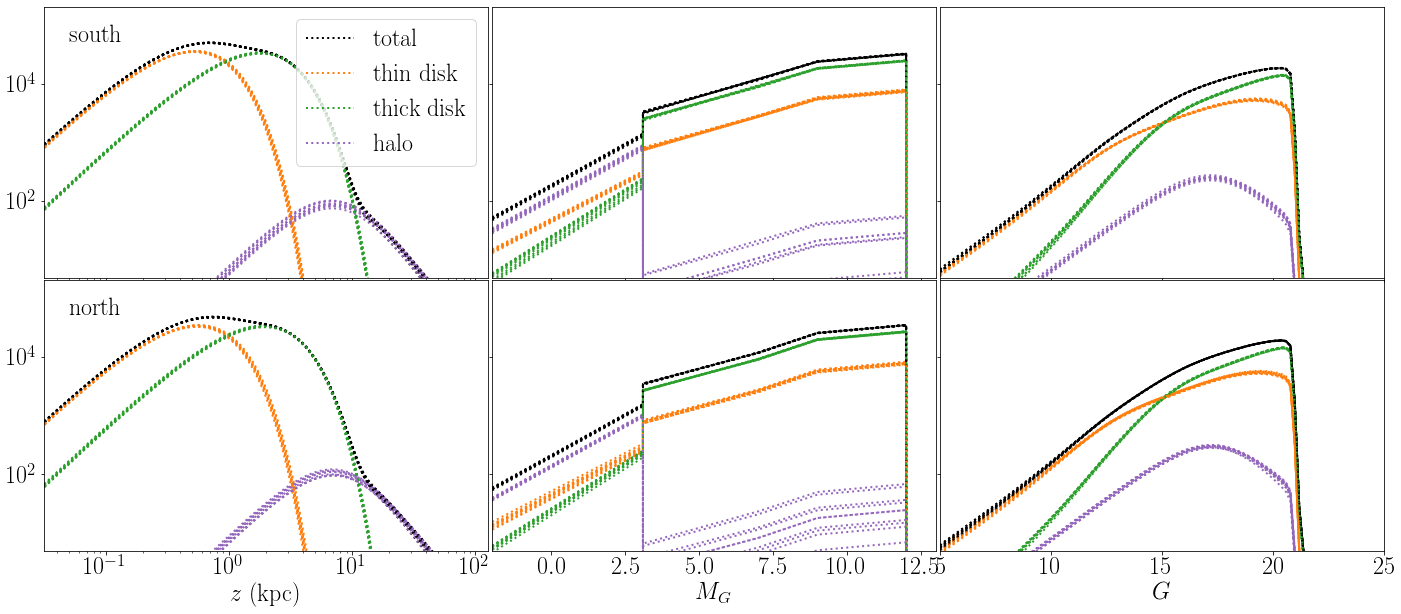

In [68]:
fig, axes = plt.subplots(2,3,figsize=(24,10), sharey=True, sharex='col')

mcmc_kwargs = ({'c':'k','alpha':1., 'linestyle':':', 'linewidth':2.}, 
               {'c':'tab:orange','alpha':1., 'linestyle':':', 'linewidth':2.}, 
               {'c':'tab:green','alpha':1., 'linestyle':':', 'linewidth':2.}, 
               {'c':'tab:purple','alpha':1., 'linestyle':':', 'linewidth':2.})

labels = ['total', 'thin disk', 'thick disk', 'halo']
cardinals=['south','north']

for jj, cardinal in enumerate(cardinals):

    nwalker, nstep, ndim = model[cardinal].mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model[cardinal].mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.1)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    for isample, mcmc_sample in enumerate(mcmc_samples):
        if isample==0: axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars), **mcmc_kwargs[0], label=labels[0])
        else: axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars), **mcmc_kwargs[0])
        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
        if isample==0: 
            for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1], label=labels[i+1]) 
        else: 
            for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 

    plt.xlim(10**zlim[0],10**zlim[1])
    if jj==0: plt.legend()
    plt.text(0.05, 5e4, cardinal)

    plt.sca(axes[jj,1])
    fixed_mags = np.array([model[cardinal].fixed_pars['Mx'], model[cardinal].fixed_pars['Mms'], 
                           model[cardinal].fixed_pars['Mms1'], model[cardinal].fixed_pars['Mms2'],
                           model[cardinal].fixed_pars[0]['Mto'], 
                           model[cardinal].fixed_pars[1]['Mto'], 
                           model[cardinal].fixed_pars[2]['Mto']])
    M_arr = np.sort(np.hstack((np.linspace(-2.,13.,100), fixed_mags-1e-5, fixed_mags+1e-5)))
    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars), **mcmc_kwargs[0])

        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 
            
            
    plt.sca(axes[jj,2])
#     if jj==0: 
#         plotting.plot_hist(sample[cardinal]['phot_g_mean_mag'], np.linspace(*mlim,50), ax=axes[jj,2], fill_poisson=True,
#                       plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})

#     if jj==0: model[cardinal].fid_pars['gsf_pars'] = app_pars
    model[cardinal].fid_pars['gsf_pars'] = gsf_pars
    m_arr = model[cardinal].fid_pars['gsf_pars']['_m_grid'].copy()
    for mcmc_sample in mcmc_samples:
        components = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal].fid_pars)
        axes[jj,2].plot(m_arr, np.sum(components, axis=0), **mcmc_kwargs[0])
        for i in range(3): axes[jj,2].plot(m_arr, components[i], **mcmc_kwargs[i+1]) 
            
            

plt.sca(axes[1,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[1,1]); plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1])
plt.sca(axes[1,2]); plt.yscale('log'); plt.xlabel(r'$G$'); plt.xlim(mlim)    
    
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.ylim(5.,200000)#100000000)

plt.savefig(f'figs/mock_{file}_{size}_{run_id:03d}_zMG_disthist.png', bbox_inches='tight', dpi=200)

In [33]:
sample['north'].keys()

dict_keys(['astrometric_params_solved', 'b', 'bp_rp', 'l', 'nu_eff_used_in_astrometry', 'parallax', 'parallax_error', 'phot_g_corr', 'phot_g_mean_mag', 'pseudocolour', 'source_id', 'zeropoint'])

# Results table

In [19]:
import math

In [20]:
model['north']._generate_fid_pars()
functions = [model['north'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north'].free_pars[j]]

Got Selectionfunction pars


In [21]:
plabels=[];
for cmpt in np.arange(len(model['north'].components)).tolist()+['shd',]:
    for par in model['north'].free_pars[cmpt]:
        plabels+=[label_dict[par],]
rows = ["w", "h_\\mathrm{Tn}", "f_D",
        "w", "h_\\mathrm{Tk}", "f_D",
        "w", "n_\\mathrm{H}", "f_D", "\\alpha_1", "\\alpha_2"]
ndim=len(rows)    
    
percentiles = np.zeros((4,ndim,3))
for jj, cardinal in enumerate(['north', 'south', 'north_Mto', 'south_Mto']):

    nwalker, nstep, ndim = model[cardinal].mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model[cardinal].mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2)::3].reshape(-1,ndim)
    percentiles[jj] = np.percentile(flat_chain, (16,50,84), axis=0).T
    
    idw = [0,3,6]
#     percentiles[jj,idw] = np.percentile(flat_chain[:,idw] - scipy.special.logsumexp(flat_chain[:,idw], axis=1)[:,None], 
#                                         (0.16,0.5,0.84), axis=0).T
    
output = "\hline\hline "
cmpt_labels = ['Thin disk', 'Thick disk', 'Halo', 'Shared']
fp_prec = [2,3,4,2,3,4,2,3,4,3,3]
ic = 0; output += f"\n {cmpt_labels[ic]}"
for ii in range(ndim):
    output += f"""\n & ${rows[ii]}$"""
    for jj, cardinal in enumerate(['north', 'south', 'north_Mto', 'south_Mto']):
        perc_f = functions[ii](percentiles[jj,ii])
        p10 = math.floor(np.log10(np.abs(perc_f[1])))
        if p10 in [-1,1]: p10=0
        output += f""" \n & ${{{format(round(perc_f[1]/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}\
_{{{format(round(min(perc_f[0],perc_f[2])/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}\
^{{{format(round(max(perc_f[0],perc_f[2])/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}"""
        if p10 == 0: output +=  "$"
        else: output +=  f"\\times 10^{{{p10}}}$"
    output += "\\\\"
    if ii in [2,5,8]:
        output += f"\n & $M_\\mathrm{{TO}}$ & {model['north'].fixed_pars[ic]['Mto']} & {model['south'].fixed_pars[ic]['Mto']} & {model['north_Mto'].fixed_pars[ic]['Mto']} & {model['south_Mto'].fixed_pars[ic]['Mto']} \\\\"
        output += f"\n & $\\alpha_3$ & {model[cardinal].fixed_pars[ic]['alpha3']} & & & \\\\"
        output += f"\n \hline\hline"
        ic += 1; output += f"\n {cmpt_labels[ic]}"
output += "\hline\hline \n"

In [22]:
print(output)

\hline\hline 
 Thin disk
 & $w$ 
 & ${1.95}_{1.91}^{2.00}\times 10^{5}$ 
 & ${1.83}_{1.79}^{1.86}\times 10^{5}$ 
 & ${1.82}_{1.78}^{1.85}\times 10^{5}$ 
 & ${1.76}_{1.73}^{1.79}\times 10^{5}$\\
 & $h_\mathrm{Tn}$ 
 & ${0.262}_{0.260}^{0.264}$ 
 & ${0.240}_{0.238}^{0.242}$ 
 & ${0.255}_{0.253}^{0.257}$ 
 & ${0.236}_{0.235}^{0.238}$\\
 & $f_D$ 
 & ${0.9878}_{0.9874}^{0.9881}$ 
 & ${0.9858}_{0.9854}^{0.9862}$ 
 & ${0.9898}_{0.9894}^{0.9901}$ 
 & ${0.9884}_{0.9881}^{0.9888}$\\
 & $M_\mathrm{TO}$ & 3.1 & 3.1 & 2.9 & 2.9 \\
 & $\alpha_3$ & -0.6 & & & \\
 \hline\hline
 Thick disk
 & $w$ 
 & ${6.39}_{6.35}^{6.43}\times 10^{5}$ 
 & ${6.52}_{6.48}^{6.56}\times 10^{5}$ 
 & ${6.50}_{6.46}^{6.53}\times 10^{5}$ 
 & ${6.58}_{6.54}^{6.62}\times 10^{5}$\\
 & $h_\mathrm{Tk}$ 
 & ${0.719}_{0.713}^{0.725}$ 
 & ${0.649}_{0.645}^{0.653}$ 
 & ${0.704}_{0.699}^{0.709}$ 
 & ${0.643}_{0.640}^{0.647}$\\
 & $f_D$ 
 & ${0.9948}_{0.9947}^{0.9950}$ 
 & ${0.9943}_{0.9942}^{0.9945}$ 
 & ${0.9949}_{0.9948}^{0.9951}$ 
 